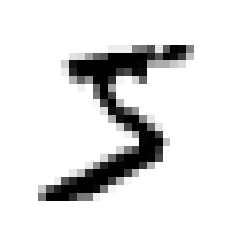

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

X, y = mnist["data"], mnist["target"]
X, y = X.to_numpy(), y.to_numpy()
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [19]:
from sklearn.linear_model import SGDClassifier

y = y.astype(np.uint8) # convert to string to unsigned integer
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [20]:
#Strattified sampling
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


### Confusion matrix

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_predict)

## TN FP
## FN TP

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_predict)) #Times it is correct
print(recall_score(y_train_5, y_train_predict)) #TImes it is detected

f1_score(y_train_5, y_train_predict)

0.8370879772350012
0.6511713705958311


0.7325171197343846

##### Get the threshold values used in the training with the precision and recall accuracy

In [23]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

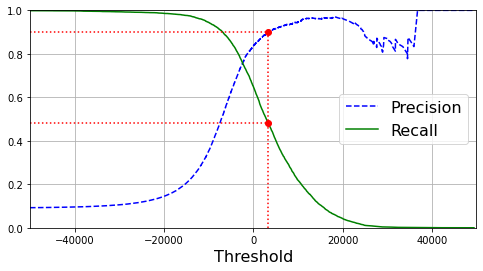

In [31]:
def plot_precision_recall_vs_threshold(precision: np.ndarray, recalls: np.ndarray, thresholds: np.ndarray):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 3370
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # 0.43

plt.figure(figsize=(8, 4)) 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

Looking for the highest recall without the precision drop that happens around 0.8 recall

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

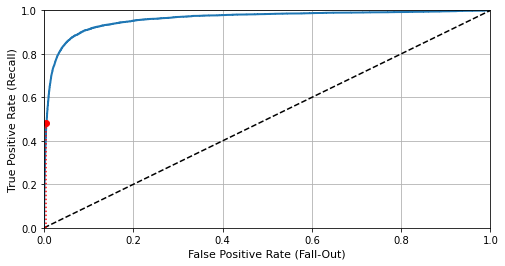

In [56]:
from sklearn.metrics import roc_curve # True positive rate against false positive rate

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, label: str = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=11)
    plt.ylabel("True Positive Rate (Recall)", fontsize=11)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])  

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]  

plt.figure(figsize=(8, 4))
plot_roc_curve(fpr, tpr)
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()